# Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from kernels import rbf_kernel
from loess import *

# One-dimensional Example

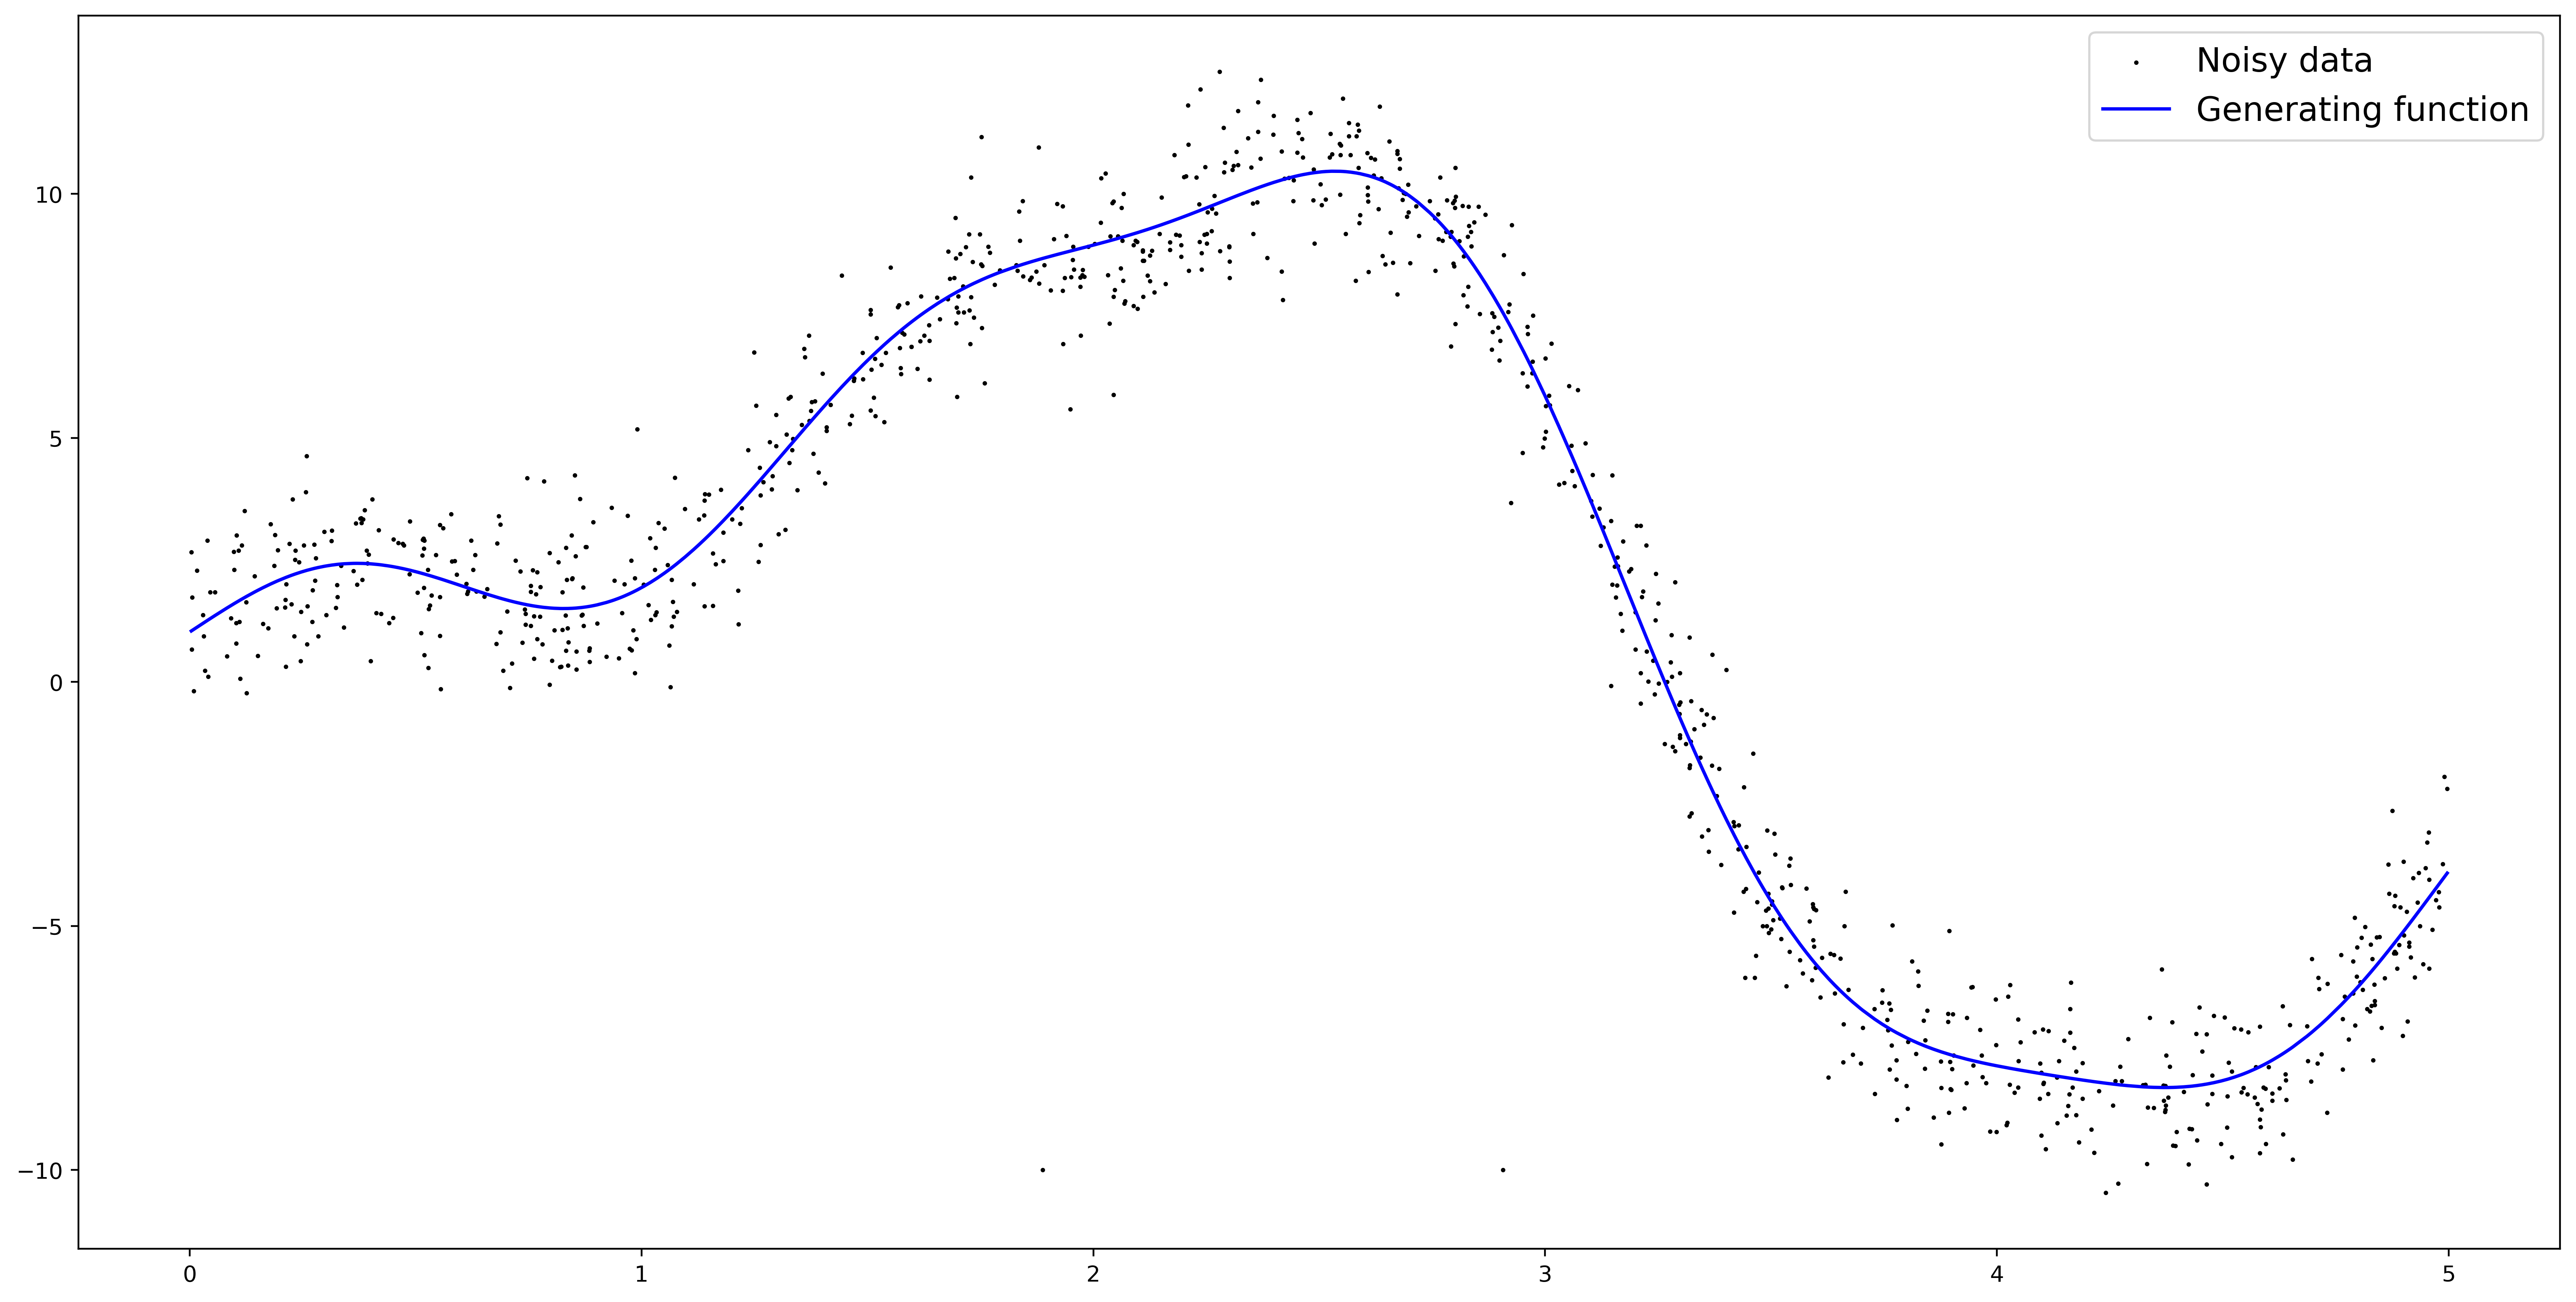

In [2]:
n = 1000

x = np.random.uniform(0, 5, n)
eps = np.random.normal(0, 1, n)
generating = np.sin(x) + np.sin(5*x) + np.cos(1/10 * x) + 10*np.exp(- (x - 2.5)**2 ) - 10*np.exp(- (x - 4)**2 )
y = generating + eps

# Add some outliers
y[150] = -10
y[300] = -10

plt.figure(figsize = (20, 10), dpi = 400)
plt.scatter(x, y, s = 1, color = 'black', label = 'Noisy data', alpha = 1)
out = np.hstack((x.reshape(-1, 1), generating.reshape(-1, 1)))
out = out[np.argsort(out[:, 0]), :]
plt.plot(out[:, 0], out[:, 1], color = 'blue', label = 'Generating function')
plt.legend(fontsize = 15)
plt.show()

In [3]:
( ( y - generating ) **2 ).mean()

1.6790094125235555

In [4]:
y_hat0 = fit_loess(x, y, anchors = None, degree = 0, kernel = rbf_kernel, alpha = 0.15, frac = None, robust_iters = 4)
y_hat1 = fit_loess(x, y, anchors = None, degree = 1, kernel = rbf_kernel, alpha = 0.15, frac = None, robust_iters = 4)
y_hat2 = fit_loess(x, y, anchors = None, degree = 2, kernel = rbf_kernel, alpha = 0.15, frac = None, robust_iters = 4)
y_hat3 = fit_loess(x, y, anchors = None, degree = 3, kernel = rbf_kernel, alpha = 0.15, frac = None, robust_iters = 4)

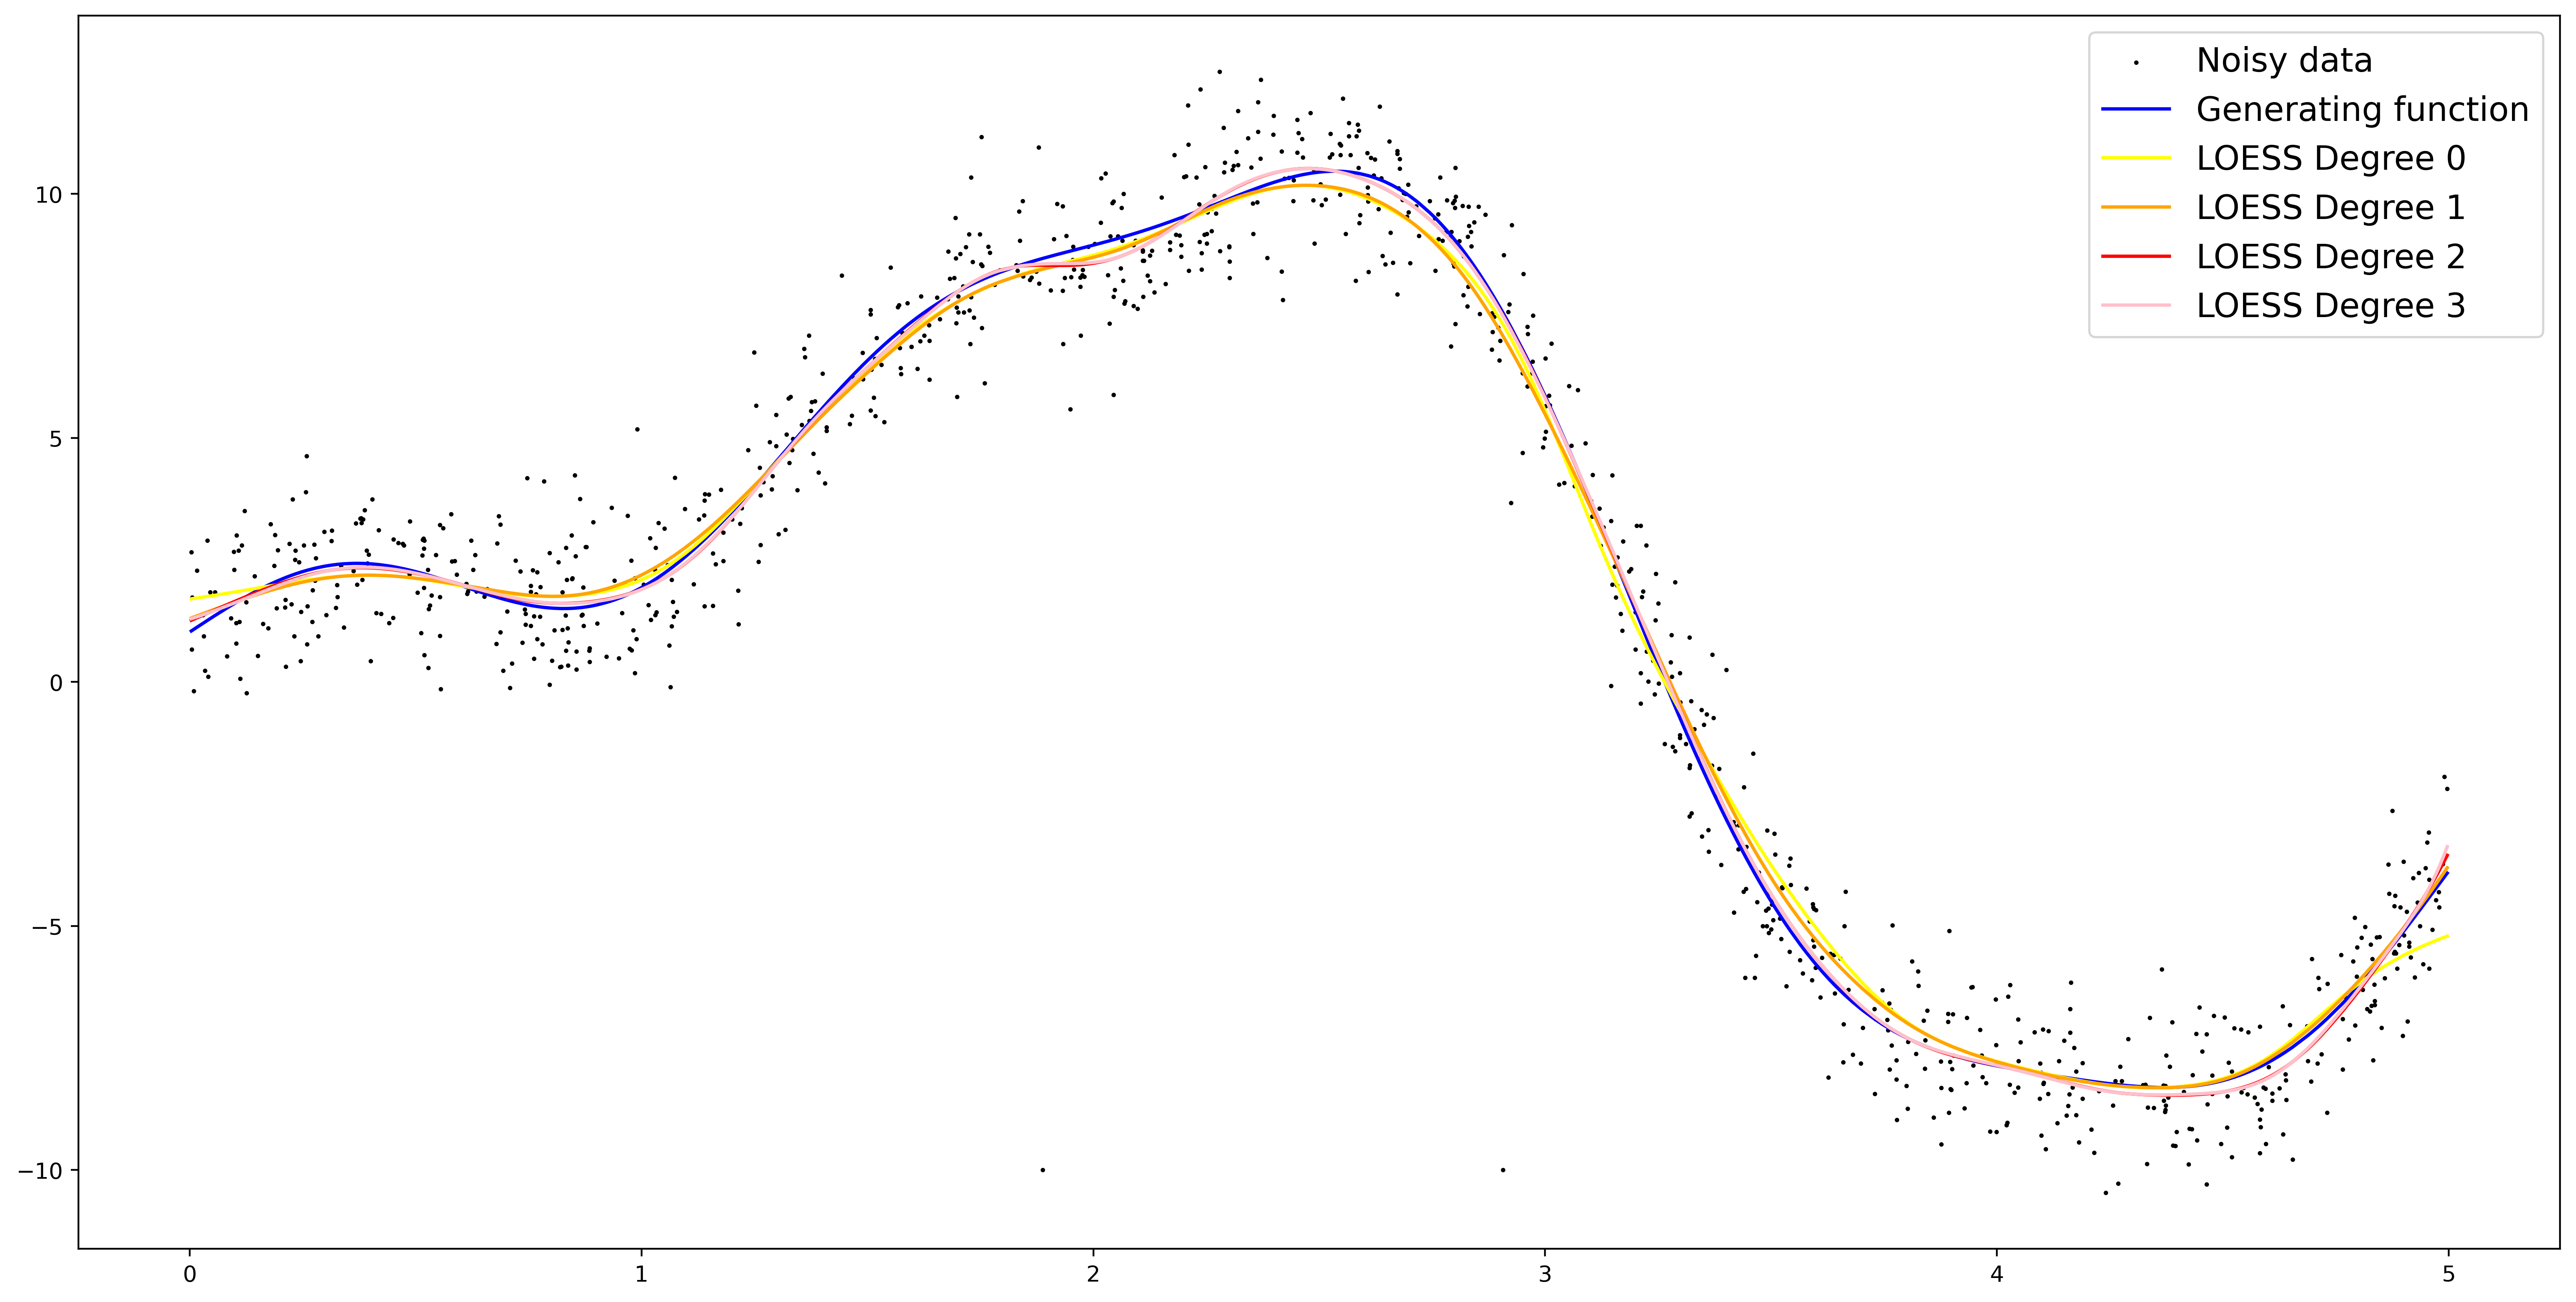

In [5]:
anchors = x

plt.figure(figsize = (20, 10), dpi = 400)
plt.scatter(x, y, s = 1, color = 'black', label = 'Noisy data', alpha = 1)

out = np.hstack((x.reshape(-1, 1), generating.reshape(-1, 1)))
out = out[np.argsort(out[:, 0]), :]
plt.plot(out[:, 0], out[:, 1], color = 'blue', label = 'Generating function')

out = np.hstack((anchors.reshape(-1, 1), y_hat0.reshape(-1, 1)))
out = out[np.argsort(out[:, 0]), :]
plt.plot(out[:, 0], out[:, 1], color = 'yellow', label = 'LOESS Degree 0')

out = np.hstack((anchors.reshape(-1, 1), y_hat1.reshape(-1, 1)))
out = out[np.argsort(out[:, 0]), :]
plt.plot(out[:, 0], out[:, 1], color = 'orange', label = 'LOESS Degree 1')

out = np.hstack((anchors.reshape(-1, 1), y_hat2.reshape(-1, 1)))
out = out[np.argsort(out[:, 0]), :]
plt.plot(out[:, 0], out[:, 1], color = 'red', label = 'LOESS Degree 2')

out = np.hstack((anchors.reshape(-1, 1), y_hat3.reshape(-1, 1)))
out = out[np.argsort(out[:, 0]), :]
plt.plot(out[:, 0], out[:, 1], color = 'pink', label = 'LOESS Degree 3')

plt.legend(fontsize = 15)
plt.show()


In [6]:
( ( y - y_hat0 ) **2 ).mean()

1.7451451687237662

In [7]:
( ( y - y_hat1 ) **2 ).mean()

1.6890869665486972

In [8]:
( ( y - y_hat2 ) **2 ).mean()

1.6435085559630118

In [9]:
( ( y - y_hat3 ) **2 ).mean()

1.6431366354658854

# Two-dimensional Example

In [10]:
n = 10000

x = np.random.rand(n, 2)

def f(x,y):
    return np.cos( 2 * np.pi * x ) * ( 1 - 3*np.sin(y) )

eps = np.random.normal(0, 0.1, n)
y = f(x[:, 0], x[:, 1]) + eps

m = np.arange(0, 1, 0.05)
anchor_x, anchor_y = np.meshgrid(m, m)
anchors = np.array([np.ravel(anchor_x), np.ravel(anchor_y)]).T

y_hat = fit_loess(x, y, anchors = anchors, degree = 2, kernel = rbf_kernel, alpha = 1, frac = 0.15)
y_hat = y_hat.reshape(anchor_x.shape)

IndexError: index 9182 is out of bounds for axis 0 with size 400

In [ ]:
fig = plt.figure(figsize = (25, 8))
ax = fig.add_subplot(111, projection = '3d')

generating = f(anchor_x, anchor_y)
generating = generating.reshape(anchor_x.shape)
ax.plot_wireframe(anchor_x, anchor_y, generating, rcount = 20, ccount = 20, color = 'blue', label = 'Generating function')
ax.scatter(x[:,0], x[:,1], y, '.', color = 'black', alpha = 0.25, label = 'Noisy data', s = 1)
ax.plot_wireframe(anchor_x, anchor_y, y_hat, rcount = 20, ccount = 20, color = 'red', label = 'LOESS Degree 2')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.legend()

ax.view_init(40, 140)